trying to reproduce: 
    
    
    
[https://www.cs.toronto.edu/~hinton/science.pdf](https://www.cs.toronto.edu/~hinton/science.pdf)

In [1]:
%matplotlib inline

In [2]:
import pylab as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784) / 255
x_test = x_test.reshape(10000, 784) / 255

In [3]:
import tensorflow as tf

In [4]:
if not tf.test.is_gpu_available():
    print("No GPU was detected")

In [5]:
mu = x_train.mean(axis=0)
U,s,V = np.linalg.svd(x_train - mu, full_matrices=False)
Zpca = np.dot(x_train - mu, V.transpose())

Rpca = np.dot(Zpca[:,:2], V[:2,:]) + mu    # reconstruction
err = np.sum((x_train-Rpca)**2)/Rpca.shape[0]/Rpca.shape[1]
print('PCA reconstruction error with 2 PCs: ' + str(round(err,3)));

PCA reconstruction error with 2 PCs: 0.056


In [6]:
m = Sequential()
m.add(Dense(512,  activation='elu', input_shape=(784,)))
m.add(Dense(128,  activation='elu'))
m.add(Dense(2,    activation='linear', name="bottleneck"))
m.add(Dense(128,  activation='elu'))
m.add(Dense(512,  activation='elu'))
m.add(Dense(784,  activation='sigmoid'))

m.compile(loss='mean_squared_error', optimizer = Adam())

history = m.fit(x_train, x_train, batch_size=128, epochs=30, verbose=1, 
                validation_data=(x_test, x_test))


encoder = Model(m.input, m.get_layer('bottleneck').output)

Zenc = encoder.predict(x_train)  # bottleneck representation

Renc = m.predict(x_train)        # reconstruction

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0559 - val_loss: 0.0486
Epoch 2/30
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0464 - val_loss: 0.0449
Epoch 3/30
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0438 - val_loss: 0.0431
Epoch 4/30
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0423 - val_loss: 0.0418
Epoch 5/30
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0412 - val_loss: 0.0412
Epoch 6/30
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0404 - val_loss: 0.0404
Epoch 7/30
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0399 - val_loss: 0.0400
Epoch 8/30
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0394 - val_loss: 0.0395
Epoch 9/30
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0390 - val_

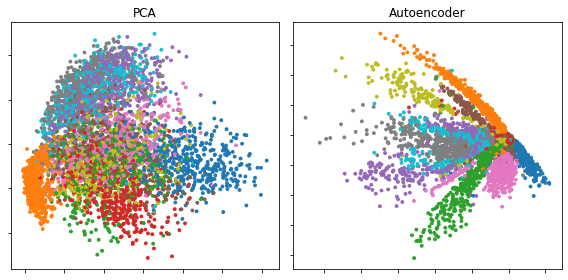

In [7]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PCA')
plt.scatter(Zpca[:5000,0], Zpca[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.subplot(122)
plt.title('Autoencoder')
plt.scatter(Zenc[:5000,0], Zenc[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.tight_layout()

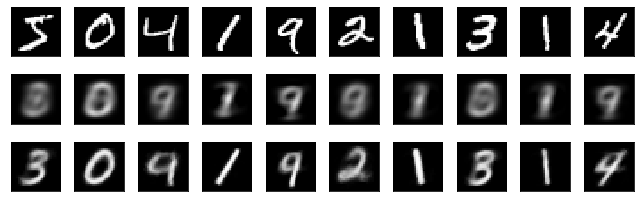

In [8]:
plt.figure(figsize=(9,3))
toPlot = (x_train, Rpca, Renc)
for i in range(10):
    for j in range(3):
        ax = plt.subplot(3, 10, 10*j+i+1)
        plt.imshow(toPlot[j][i,:].reshape(28,28), interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout()

In [9]:
from numba import cuda 

In [10]:
device = cuda.get_current_device()

In [11]:
device.reset()